In [1]:
cd /home/esteban/Documents/Crypto/algorithmic-trading/

/home/esteban/Documents/Crypto/algorithmic-trading


## Get the data

In [2]:
from urllib.error import HTTPError
import pandas as pd
import numpy as np
import talib

In [3]:
def get_data(symbol: str, time_frame: str, start: str, end: str) -> pd.DataFrame:
    """
    Imports the data.
    
    Parameters
    ----------
    symbol: str
        symbol of the pair to download.
    time_frame: str
        time frame (1m, 5m, 15m, 30m, 1h, ...).
    start: str
        start date in format YYYY-mm-dd.
    end: str
        end date in format YYYY-mm-dd.
    Returns
    -------
    pd.DataFrame
        OHLCV data within the specified time range.
    """
    dates = pd.date_range(start=pd.to_datetime(start).replace(day=1),
                          end=pd.to_datetime(end) + pd.DateOffset(months=1),
                          freq='MS')
    data = []
    for date in dates:
        date_ = date.strftime(format="%Y-%m")
        filepath = "https://data.binance.vision/data/spot/monthly/klines/" \
                   f"{symbol}/{time_frame}/" \
                   f"{symbol}-{time_frame}-{date_}.zip"
        try:
            data_date = pd.read_csv(
                filepath,
                usecols=range(6),
                names=["Timestamp", "Open", "High", "Low", "Close", "Volume"]
            )
        except HTTPError:
            print(f"No data found in {filepath}.")
            continue

        data_date.index = pd.to_datetime(data_date['Timestamp'], unit='ms')
        data_date.index.name = "Datetime"
        data_date.drop(columns=["Timestamp"], inplace=True)
        data.append(data_date)

    raw = pd.concat(data, axis=0)
    return raw

In [4]:
data = get_data(symbol='BTCUSDT',
                time_frame='1h',
                start='2017-08-01', 
                end='2022-03-01')

No data found in https://data.binance.vision/data/spot/monthly/klines/BTCUSDT/1h/BTCUSDT-1h-2022-04.zip.


In [5]:
data

,Open,High,Low,Close,Volume
Datetime,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2022-03-31 19:00:00,45957.27,45987.94,45500.00,45581.97,2165.488340
2022-03-31 20:00:00,45581.98,45790.00,45519.03,45745.46,1550.113570
2022-03-31 21:00:00,45745.45,45849.99,45647.01,45757.19,887.898900


In [6]:
# Calculate features
data['log_ret'] = np.log(data['Close'] / data['Close'].shift())
data['log_vol_ch'] = np.log(data['Volume'] / data['Volume'].shift())
data.loc[data['log_vol_ch'] > 3, "log_vol_ch"] = np.nan
data.loc[data['log_vol_ch'] < -3, "log_vol_ch"] = np.nan
data['rsi'] = talib.RSI(data['Close'], timeperiod=14)

/home/esteban/Documents/Crypto/algorithmic-trading/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Univariate distributions

<AxesSubplot:ylabel='Frequency'>

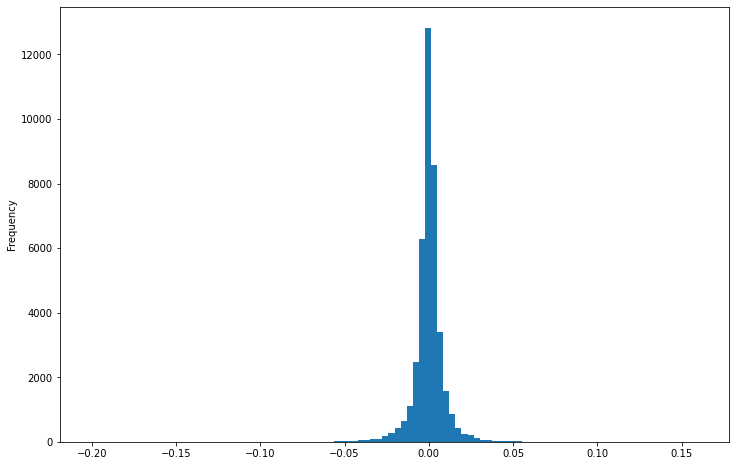

In [7]:
data['log_ret'].plot(kind="hist", bins=100, figsize=(12, 8))

<AxesSubplot:ylabel='Frequency'>

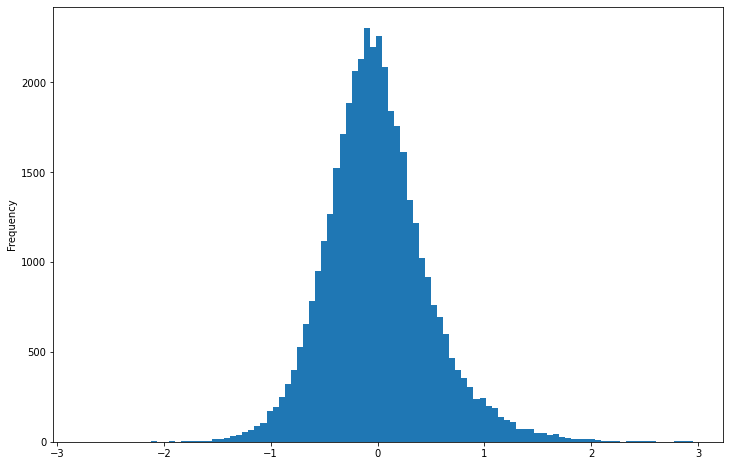

In [8]:
data['log_vol_ch'].plot(kind="hist", bins=100, figsize=(12, 8))

<AxesSubplot:ylabel='Frequency'>

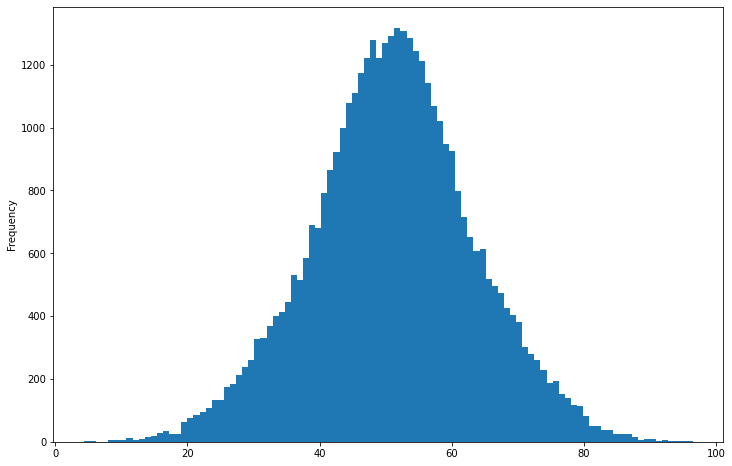

In [9]:
data['rsi'].plot(kind="hist", bins=100, figsize=(12, 8))

## Bivariate distributions

In [10]:
from pandas.plotting import scatter_matrix

array([[<AxesSubplot:xlabel='log_ret', ylabel='log_ret'>,
        <AxesSubplot:xlabel='log_vol_ch', ylabel='log_ret'>,
        <AxesSubplot:xlabel='rsi', ylabel='log_ret'>],
       [<AxesSubplot:xlabel='log_ret', ylabel='log_vol_ch'>,
        <AxesSubplot:xlabel='log_vol_ch', ylabel='log_vol_ch'>,
        <AxesSubplot:xlabel='rsi', ylabel='log_vol_ch'>],
       [<AxesSubplot:xlabel='log_ret', ylabel='rsi'>,
        <AxesSubplot:xlabel='log_vol_ch', ylabel='rsi'>,
        <AxesSubplot:xlabel='rsi', ylabel='rsi'>]], dtype=object)

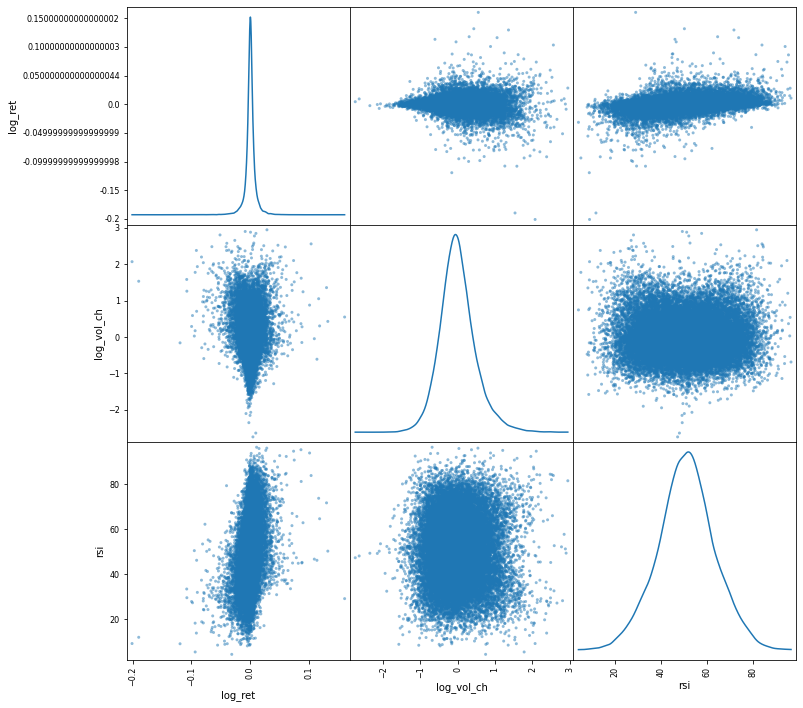

In [11]:
scatter_matrix(data[['log_ret', 'log_vol_ch', 'rsi']],
               diagonal='kde',
               alpha=0.5,
               figsize=(12, 12))

<AxesSubplot:xlabel='rsi', ylabel='log_ret'>

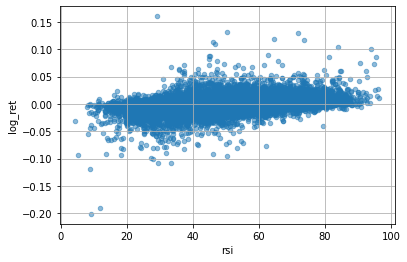

In [13]:
data.plot.scatter(x='rsi', y='log_ret', grid=True, alpha=0.5)

In the scatter plot of RSI vs. log-returns we can identify a slight positive slope, indicating that high values of the rsi indicators are associated with positive returns and the other way around.

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns

In [17]:
# Quantization
data["ret_cat"] = pd.qcut(data['log_ret'], q=10, labels=[-5, -4, -3, -2, -1, 1, 2, 3, 4, 5])
data["vol_cat"] = pd.qcut(data['Volume'], q=10, labels=[-5, -4, -3, -2, -1, 1, 2, 3, 4, 5])
data["rsi_cat"] = pd.qcut(data['rsi'], q=10, labels=[-5, -4, -3, -2, -1, 1, 2, 3, 4, 5])

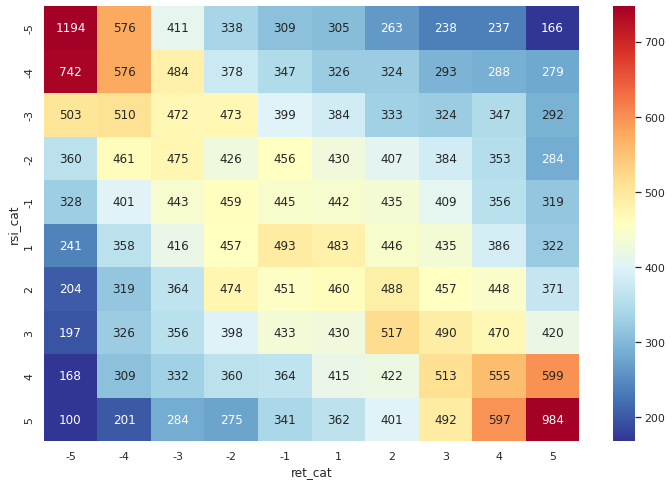

In [22]:
# Joint counts
matrix = pd.crosstab(data['rsi_cat'], data['ret_cat'])

# Plot
plt.figure(figsize=(12, 8))
sns.set(font_scale=1)
sns.heatmap(matrix, cmap="RdYlBu_r",
            annot=True, robust=True,
            fmt=".0f")
plt.show()

Which confirms our previous observation.

What does the RSI says about the returns in the near future?

In [51]:
data

,Open,High,Low,Close,Volume,log_ret,log_vol_ch,rsi,ret_cat,vol_cat,rsi_cat
Datetime,,,,,,,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,NaN,NaN,NaN,NaN,-5,NaN
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,0.001505,-0.708335,NaN,2,-5,NaN
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,0.002090,-1.167460,NaN,2,-5,NaN
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,0.005912,-0.486810,NaN,4,-5,NaN
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,0.002457,-1.518955,NaN,3,-5,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31 19:00:00,45957.27,45987.94,45500.00,45581.97,2165.488340,-0.008200,0.172530,28.255300,-5,2,-5
2022-03-31 20:00:00,45581.98,45790.00,45519.03,45745.46,1550.113570,0.003580,-0.334318,32.313129,3,1,-5
2022-03-31 21:00:00,45745.45,45849.99,45647.01,45757.19,887.898900,0.000256,-0.557226,32.607643,1,-3,-5


In [43]:
data['ret_cat'].shift(-1)

Datetime
2017-08-17 04:00:00      2
2017-08-17 05:00:00      2
2017-08-17 06:00:00      4
2017-08-17 07:00:00      3
2017-08-17 08:00:00      5
                      ... 
2022-03-31 19:00:00      3
2022-03-31 20:00:00      1
2022-03-31 21:00:00      1
2022-03-31 22:00:00     -4
2022-03-31 23:00:00    NaN
Name: ret_cat, Length: 40382, dtype: category
Categories (10, int64): [-5 < -4 < -3 < -2 ... 2 < 3 < 4 < 5]

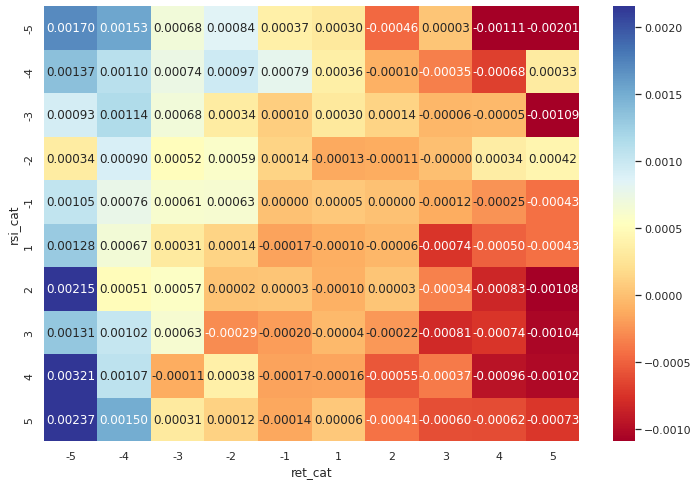

In [50]:
# Joint mean
matrix = pd.crosstab(data['rsi_cat'], data['ret_cat'],
                     values=data['log_ret'].shift(-1),
                     aggfunc='median')
plt.figure(figsize=(12, 8))
sns.set(font_scale=1)
sns.heatmap(matrix, cmap="RdYlBu", 
            annot=True, robust=True,
            fmt=".5f")
plt.show()